In [1]:
import infofile # local file containing cross-sections, sums of weights, dataset IDs
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import matplotlib_inline # to edit the inline plot format
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') # to make plots in pdf (vector) format
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time

In [2]:
MeV = 0.001
GeV = 1.0


path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" 


samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'], # data is from 2016, first four periods of data taking (ABCD)
    },

    r'Background $Z,t\bar{t}$' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },

    r'Background $ZZ^*$' : { # ZZ
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },

    r'Signal ($m_H$ = 125 GeV)' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#00cdff" # light blue
    },

}


variables = ['lep_pt','lep_eta','lep_phi','lep_E','lep_charge','lep_type']
weight_variables = ["mcWeight", "scaleFactor_PILEUP", "scaleFactor_ELE", "scaleFactor_MUON", "scaleFactor_LepTRIGGER"]


lumi = 10
cutoffs = [30, 20, 10]
fraction = 1.0 # reduce this is if you want quicker runtime (implemented in the loop over the tree)

In [3]:
# Cut lepton type (electron type is 11,  muon type is 13)
def cut_lep_type(lep_type):
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
    lep_type_cut_bool = (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)
    return lep_type_cut_bool # True means we should remove this entry (lepton type does not match)

# Cut lepton charge
def cut_lep_charge(lep_charge):
    # first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    sum_lep_charge = lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3] != 0
    return sum_lep_charge # True means we should remove this entry (sum of lepton charges is not equal to 0)

# Calculate invariant mass of the 4-lepton state
# [:, i] selects the i-th lepton in each event
def calc_mass(lep_pt, lep_eta, lep_phi, lep_E):
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_E})
    invariant_mass = (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M * MeV # .M calculates the invariant mass
    return invariant_mass

def calc_weight(weight_variables, sample, events, lumi):
    info = infofile.infos[sample]
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    total_weight = xsec_weight 
    for variable in weight_variables:
        total_weight = total_weight * events[variable]
    return total_weight

In [4]:
# Define empty dictionary to hold awkward arrays
all_data = {} 

# Loop over samples
for s in samples: 
    # Print which sample is being processed
    print('Processing '+s+' samples') 
    sample_start = time.time() # start the clock

    # Define empty list to hold data
    frames = [] 
    
    print(f"Number of files: {len(samples[s]['list'])}")
    # Loop over each file
    for val in samples[s]['list']: 
        if s == 'data': 
            prefix = "Data/" # Data prefix
        else: # MC prefix
            prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
        fileString = path+prefix+val+".4lep.root" # file name to open


        # start the clock
        start = time.time() 
        print("\t"+val+":") 

        # Open file
        # with uproot.open(fileString + ":mini") as t:
        #     tree = t
        t = uproot.open(fileString + ":mini")
        tree = t
        
        sample_data = []

        # Loop over data in the tree
        for data in tree.iterate(variables + weight_variables, 
                                 library="ak", 
                                 entry_stop=tree.num_entries*fraction, # process up to numevents*fraction
                                 step_size = 1000000): 
            # Number of events in this batch
            nIn = len(data) 
                                 
            # Transverse momentum records and cuts
            data['leading_lep_pt'] = data['lep_pt'][:,0]
            data['sub_leading_lep_pt'] = data['lep_pt'][:,1]
            data['third_leading_lep_pt'] = data['lep_pt'][:,2]
            data['last_lep_pt'] = data['lep_pt'][:,3]

            data = data[data['leading_lep_pt'] * MeV > cutoffs[0]]
            data = data[data['sub_leading_lep_pt'] * MeV > cutoffs[1]]
            data = data[data['third_leading_lep_pt'] * MeV > cutoffs[2]]

            # Cuts
            lep_type = data['lep_type']
            data = data[~cut_lep_type(lep_type)]
            lep_charge = data['lep_charge']
            data = data[~cut_lep_charge(lep_charge)]
            
            # Invariant Mass
            data['mass'] = calc_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_E'])

            # Store Monte Carlo weights in the data
            if 'data' not in val: # Only calculates weights if the data is MC
                data['totalWeight'] = calc_weight(weight_variables, val, data, lumi)
                nOut = sum(data['totalWeight']) # sum of weights passing cuts in this batch 
            else:
                nOut = len(data)
            elapsed = time.time() - start # time taken to process
            print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after

            # Append data to the whole sample data list
            sample_data.append(data)

        frames.append(ak.concatenate(sample_data)) 

    all_data[s] = ak.concatenate(frames) # dictionary entry is concatenated awkward arrays
    print(f"Time taken to process {s}: {time.time() - sample_start:.1f}s")

Processing data samples
Number of files: 4
	data_A:
		 nIn: 39,	 nOut: 	21	 in 0.4s
	data_B:
		 nIn: 156,	 nOut: 	66	 in 0.2s
	data_C:
		 nIn: 237,	 nOut: 	116	 in 0.2s
	data_D:
		 nIn: 400,	 nOut: 	209	 in 0.2s
Time taken to process data: 0.9s
Processing Background $Z,t\bar{t}$ samples
Number of files: 3
	Zee:
		 nIn: 898,	 nOut: 	26.915932	 in 0.2s
	Zmumu:
		 nIn: 684,	 nOut: 	28.59276	 in 0.2s
	ttbar_lep:
		 nIn: 1031,	 nOut: 	18.368776	 in 0.2s
Time taken to process Background $Z,t\bar{t}$: 0.6s
Processing Background $ZZ^*$ samples
Number of files: 1
	llll:
		 nIn: 554279,	 nOut: 	236.67665	 in 5.1s
Time taken to process Background $ZZ^*$: 5.1s
Processing Signal ($m_H$ = 125 GeV) samples
Number of files: 4
	ggH125_ZZ4lep:
		 nIn: 164716,	 nOut: 	7.929783	 in 5.1s
	VBFH125_ZZ4lep:
		 nIn: 191126,	 nOut: 	0.7252958	 in 5.4s
	WH125_ZZ4lep:
		 nIn: 15379,	 nOut: 	0.2036293	 in 0.6s
	ZH125_ZZ4lep:
		 nIn: 14485,	 nOut: 	0.0014187315	 in 0.8s
Time taken to process Signal ($m_H$ = 125 GeV

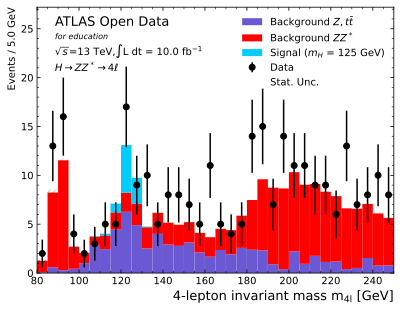

In [5]:
# x-axis range of the plot
xmin = 80 * GeV
xmax = 250 * GeV

step_size = 5 * GeV

bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

data_x,_ = np.histogram(ak.to_numpy(all_data['data']['mass']), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

signal_x = ak.to_numpy(all_data[r'Signal ($m_H$ = 125 GeV)']['mass']) # histogram the signal
signal_weights = ak.to_numpy(all_data[r'Signal ($m_H$ = 125 GeV)'].totalWeight) # get the weights of the signal events
signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

mc_x = [] # define list to hold the Monte Carlo histogram entries
mc_weights = [] # define list to hold the Monte Carlo weights
mc_colors = [] # define list to hold the colors of the Monte Carlo bars
mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

for s in samples: # loop over samples
    if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
        mc_x.append( ak.to_numpy(all_data[s]['mass']) ) # append to the list of Monte Carlo histogram entries
        mc_weights.append( ak.to_numpy(all_data[s].totalWeight) ) # append to the list of Monte Carlo weights
        mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
        mc_labels.append( s ) # append to the list of Monte Carlo legend labels

# *************
# Main plot 
# *************
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# plot the Monte Carlo bars
mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                            weights=mc_weights, stacked=True, 
                            color=mc_colors, label=mc_labels )

mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value

# calculate MC statistical uncertainty: sqrt(sum w^2)
mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

# plot the signal bar
main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                weights=signal_weights, color=signal_color,
                label=r'Signal ($m_H$ = 125 GeV)')

# plot the statistical uncertainty
main_axes.bar(bin_centres, # x
                2*mc_x_err, # heights
                alpha=0.5, # half transparency
                bottom=mc_x_tot-mc_x_err, color='none', 
                hatch="////", width=step_size, label='Stat. Unc.' )

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )

# add minor ticks on y-axis for main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# Add text 'ATLAS Open Data' on plot
plt.text(0.05, # x
            0.93, # y
            'ATLAS Open Data', # text
            transform=main_axes.transAxes, # coordinate system used is that of main_axes
            fontsize=13 ) 

# Add text 'for education' on plot
plt.text(0.05, # x
            0.88, # y
            'for education', # text
            transform=main_axes.transAxes, # coordinate system used is that of main_axes
            style='italic',
            fontsize=8 ) 

# Add energy and luminosity
lumi_used = str(lumi*fraction) # luminosity to write on the plot
plt.text(0.05, # x
            0.82, # y
            '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
            transform=main_axes.transAxes ) # coordinate system used is that of main_axes

# Add a label for the analysis carried out
plt.text(0.05, # x
            0.76, # y
            r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
            transform=main_axes.transAxes ) # coordinate system used is that of main_axes

# draw the legend
main_axes.legend( frameon=False ) # no box around the legend